<a href="https://colab.research.google.com/github/tomasfbouvier/Invariant_mass_data_analysis/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
import tensorflow as tf




We first load the data in a data frame and check for nan values. 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/tomasfbouvier/Invariant_mass_data_analysis/main/dielectron.csv',header=0)

print(df[df.isna().any(axis=1)])


          Run      Event         E1       px1   ...      eta2      phi2  Q2   M
2354   147115  626787667   2.552450   0.783675  ... -0.009998 -1.258420  -1 NaN
4428   147115  222901013   2.537850  -1.024290  ... -0.545920 -2.054790  -1 NaN
5035   147115  251148678   2.914610   1.578570  ...  0.257513  0.977215   1 NaN
6066   146644  908463569  19.896200 -11.256100  ... -0.597517  2.304200   1 NaN
6667   146644  588243059   3.610600  -1.635780  ... -0.557335 -2.124080  -1 NaN
...       ...        ...        ...        ...  ...       ...       ...  ..  ..
95396  149182  227768088   0.994475   0.358496  ... -0.943794 -1.007160  -1 NaN
96087  149182  233450553   4.573870  -3.415140  ...  0.137831  2.425000  -1 NaN
96394  149182   99636450  12.192400   0.074398  ...  0.278666 -1.564060   1 NaN
97996  146511  240272111   5.165580  -4.391900  ...  0.381967 -2.721380   1 NaN
98830  146511   53158595   4.381430  -2.846570  ...  0.326852 -2.325030   1 NaN

[85 rows x 19 columns]


We see that NaN values are entries in the mass column, which is our target. For our purposes we have to continue without those entries. We will also remove the Run and Event entries which are not relevant for this regression exercise. Finally we check for and remove duplicate entries. 

In [3]:
df=df.dropna()
print(df.info)
print(df.keys())

#   Remove irrelevant columns:
df = df.drop(['Run', 'Event'], axis=1)

#   Remove duplicates
df = df.drop_duplicates()

<bound method DataFrame.info of           Run      Event        E1       px1   ...      eta2      phi2  Q2         M
0      147115  366639895  58.71410  -7.311320  ... -2.344030 -2.072810  -1   8.94841
1      147115  366704169   6.61188  -4.152130  ...  0.808077  2.734920   1  15.89300
2      147115  367112316  25.54190 -11.480900  ... -2.455080  2.148570   1  38.38770
3      147115  366952149  65.39590   7.512140  ...  2.330210  0.565865  -1   3.72862
4      147115  366523212  61.45040   2.952840  ... -2.423700 -1.684810  -1   2.74718
...       ...        ...       ...        ...  ...       ...       ...  ..       ...
99995  146511  522575834  12.31310 -10.658000  ...  0.307851 -1.171470   1   8.44779
99996  146511  522786431  18.46420   7.854990  ... -2.383880 -2.126960   1  20.71540
99997  146511  522906124   4.18566  -3.273500  ... -2.300410 -2.444050  -1  12.71350
99998  146511  523243830  54.46220  11.352600  ...  1.677170  1.448610   1   4.69670
99999  146511  524172389   7.6400

Now we can proceed to perform an exploratory data analysis (EDA). This will give us insights of the features that we are working with and how they might affect our target value, M. Also this allows us to look for singular values that might affect the performance of our future training.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53e653bad0>,
      dtype=object)

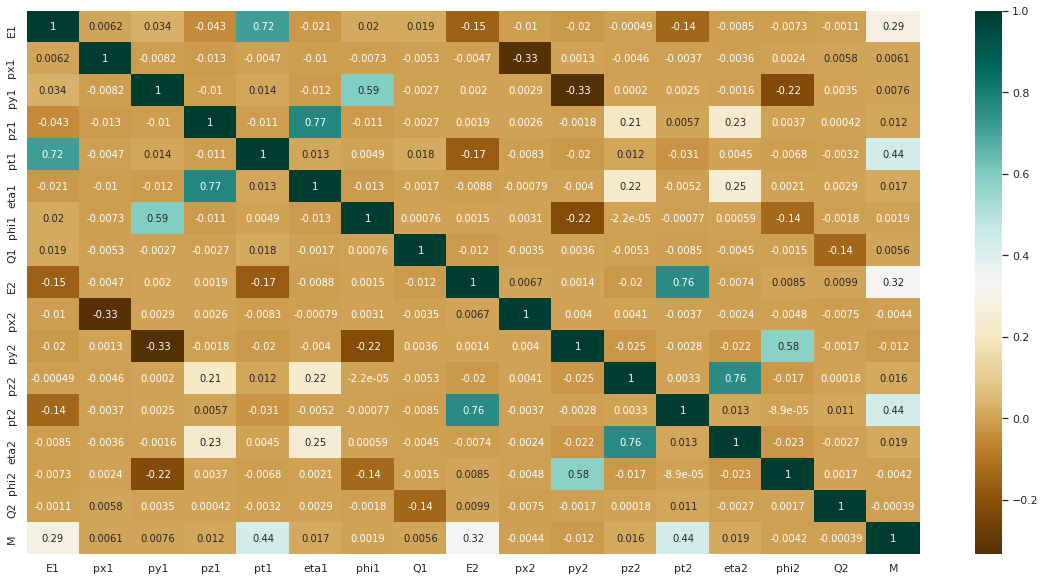

<Figure size 432x288 with 0 Axes>

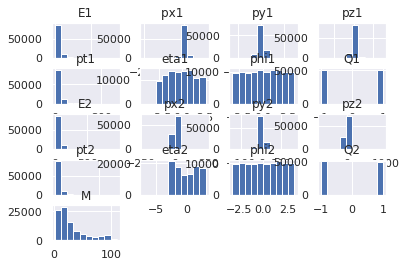

In [4]:
# EDA

plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c
plt.title('Correlation matrix')

plt.figure()
df.hist()


We shuffle the entries in case they are not randomly distributed

In [ ]:
df=df.sample(frac=1)

Now we proceed to split our data set into input and target values and this into training and testing sets. Moreover, we perform the normalization and standarisation of our input features in order to make it easier for our model to process them

In [ ]:
split_size=0.9 # ratio training/overall

size=df.shape[0]

X=df.iloc(1)[:-1].values.copy()
y= df.iloc(1)[-1].values.copy()

print(y)
X= (X -X.mean(axis=0).T[None,:])/X.std(axis=0).T[None,:]
#X /= X.std(axis=0).T[None,:]

print(np.mean(y))
#y -= y.mean()
#y /= y.std()


X_train= X[:int(0.9*size)]
y_train= y[:int(0.9*size)]

X_test= X[int(0.9*size):]
y_test= y[int(0.9*size):]



[47.4511  16.5078   3.17938 ... 10.8687  13.964   24.7005 ]
30.020881689624794


Let's first build a baseline from which we can improve our results. 
We perform a simple linear regression of our data:

0.28477304464841435


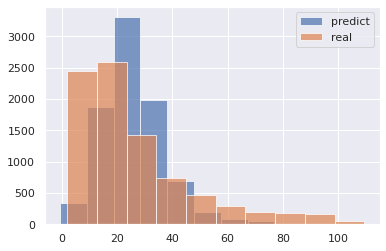

In [ ]:

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_test, y_test))
plt.hist(reg.predict(X_test), alpha=0.7)
plt.hist(y_test, alpha=0.7)

plt.legend(['predict', 'real'])

Not bad but there is much to improve. For this we build a more complex function. Since we don't have any inference of the functional form of our problem, a neural network is perfect for this problem. 

In [ ]:


def model(p):
  NN_model=tf.keras.models.Sequential()
  NN_model.add(tf.keras.layers.Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation=p['activation'], kernel_regularizer='l1'))
  NN_model.add(tf.keras.layers.Dropout(p['Dropout']))
  # The Hidden Layers :

  for i in range(p['hidden_layers']):
    NN_model.add(tf.keras.layers.Dense(p['hidden_layers_neurons'], kernel_initializer='normal',activation=p['activation'], kernel_regularizer=p['regularizer']))
    NN_model.add(tf.keras.layers.Dropout(p['Dropout']))

  # The Output Layer :
  NN_model.add(tf.keras.layers.Dense(1, kernel_initializer='normal',activation='relu'))

  # Compile the network :
  NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
  #NN_model.summary()
  return NN_model






{'hidden_layers': 4, 'hidden_layers_neurons': 128, 'Dropout': 0.0, 'batch_size': 32, 'epochs': 10, 'activation': 'relu', 'optimizer': 'adam', 'regularizer': 'l1'}
Epoch 1/10
2810/2810 [==============================] - 10s 3ms/step - loss: 63.3721 - mean_absolute_error: 3.8865 - val_loss: 22.1367 - val_mean_absolute_error: 2.1131
Epoch 2/10
2810/2810 [==============================] - 9s 3ms/step - loss: 19.7183 - mean_absolute_error: 2.0675 - val_loss: 15.8668 - val_mean_absolute_error: 1.8149
Epoch 3/10
2810/2810 [==============================] - 9s 3ms/step - loss: 14.2141 - mean_absolute_error: 1.7313 - val_loss: 10.7715 - val_mean_absolute_error: 1.3913
Epoch 4/10
2810/2810 [==============================] - 9s 3ms/step - loss: 11.3570 - mean_absolute_error: 1.5401 - val_loss: 15.2080 - val_mean_absolute_error: 2.2540
Epoch 5/10
2810/2810 [==============================] - 9s 3ms/step - loss: 9.3941 - mean_absolute_error: 1.3682 - val_loss: 9.6790 - val_mean_absolute_error: 1.565

Note that we have left many of the hyperparameters the NN as arguments of the function used for defining the model. With this, we can now search for the optimal hyperparameters that minimize the loss function: mean squared error. 



In [ ]:
# Manual hyperparameter search

import itertools

def combinated_dict(my_dict):
  keys, values = zip(*my_dict.items())
  permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

  return permutations_dicts


params={'hidden_layers':[2,3,4,5], 'hidden_layers_neurons':[64,128,256], 'Dropout':[0.,0.1,0.2,0.3, 0.4], 'batch_size':[16,32,64,128], 'activation': ['relu', 'elu'], 'regularizer':[None, 'l1', 'l2'] }

def search(params_boundaries):
  histories=[]
  for p in combinated_dict(params_boundaries):
    sample_model=model(p)
    print(p)
    history=sample_model.fit(X_train, y_train, epochs=p['epochs'], batch_size=p['batch_size'], validation_data=(X_test,y_test))
    histories.append(history)
    del sample_model

  return histories


search_results=search(params)

With the optimal parameters we perform a long training of our NN.

Epoch 1/50
2810/2810 [==============================] - 10s 3ms/step - loss: 77.7779 - mean_absolute_error: 4.4263 - val_loss: 32.3340 - val_mean_absolute_error: 3.1851
Epoch 2/50
2810/2810 [==============================] - 9s 3ms/step - loss: 21.3005 - mean_absolute_error: 2.2521 - val_loss: 16.8275 - val_mean_absolute_error: 1.9978
Epoch 3/50
2810/2810 [==============================] - 9s 3ms/step - loss: 15.3180 - mean_absolute_error: 1.8812 - val_loss: 11.8008 - val_mean_absolute_error: 1.6034
Epoch 4/50
2810/2810 [==============================] - 9s 3ms/step - loss: 11.7814 - mean_absolute_error: 1.6545 - val_loss: 10.4419 - val_mean_absolute_error: 1.5884
Epoch 5/50
2810/2810 [==============================] - 9s 3ms/step - loss: 10.5606 - mean_absolute_error: 1.5834 - val_loss: 11.7957 - val_mean_absolute_error: 1.8614
Epoch 6/50
2810/2810 [==============================] - 9s 3ms/step - loss: 8.9672 - mean_absolute_error: 1.4483 - val_loss: 8.5023 - val_mean_absolute_error: 

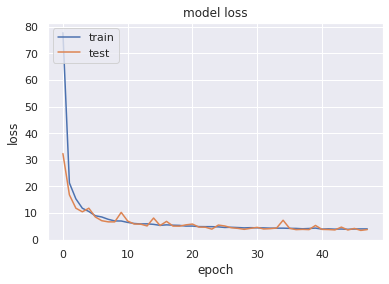

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

best_p= {'hidden_layers':4, 'hidden_layers_neurons':128, 'Dropout':0., 'batch_size':32, 'activation': 'relu', 'regularizer':'l1' }


NN_model= model(best_p)

history=NN_model.fit(X_train, y_train, epochs=50, batch_size=best_p['batch_size'], validation_data=(X_test,y_test), callbacks=[callback])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()



Finally, we proceed to evaluate the performance of our moddel by making a scatter plot of the predictions vs the target values. 

pearsonr (0.9985709680148457, 0.0)


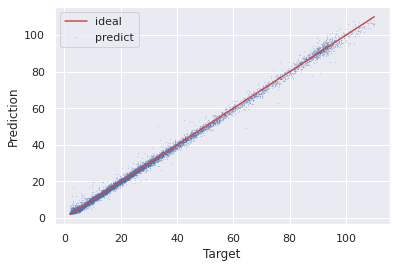

In [ ]:
from scipy.stats import pearsonr

plt.scatter(y_test,NN_model.predict(X_test),s = 0.01)

x=np.linspace(min(y_test), max(y_test),100)
plt.plot(x,x, 'r')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.legend(['ideal', 'predict'])
print('pearsonr', pearsonr(y_test,  (NN_model.predict(X_test)[:,0])) )

In general the predictions are near the ideal line. For low masses we can see that the predictions are tiny under the line. For higher masses the prediction broadens around the line. We can also notice some exceptional data that our model is not able to predict properly.
